## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.6,
 5: 26.0,
 10: 26.7,
 20: 27.7,
 30: 28.6,
 40: 29.7,
 50: 31.3,
 60: 33.3,
 70: 35.4,
 80: 37.9,
 90: 41.5,
 95: 44.6,
 99: 50.301000000000016}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.15 weight on <Distribution> lognorm(mean=2.47, sd=0.32)},
 'integration': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.39, sd=0.61)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distri

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples)

100%|████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1055967.77it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00030768155213996843,
 50: 0.00039621840428834005,
 60: 0.0005080574959147942,
 70: 0.000697002432374753,
 80: 0.0010534101059209355,
 90: 0.0020541701534809317,
 95: 0.0037448039391551166,
 99: 0.009177069407012264}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.1e+09',
 50: '9.1e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '4.7e+10',
 95: '8.6e+10',
 99: '2.1e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 42.4 log FLOP (~3 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~54 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 4.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 42.4 log FLOP (3 billion decillion) - log $ 24.1 to buy TAI (1 septillion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (120 septillion) available - TAI takes 42.1 log FLOP (1 billion decillion) - log $ 23.7 to buy TAI (487 sextillion) vs. willingness to pay log $ 7.7 (46 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (182 

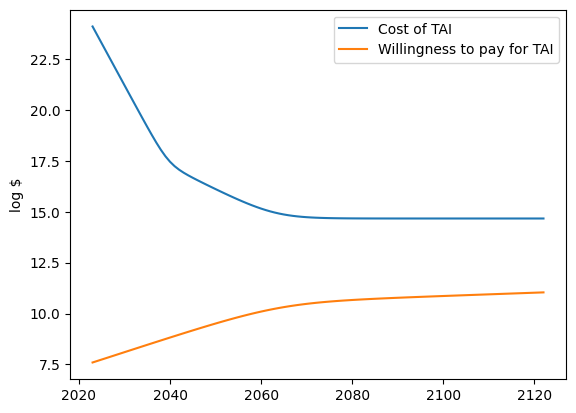

-
-
## SAMPLE RUN 2 ##
It takes 49.7 log FLOP (~50 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~14 septillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 3.8 years to a max of 0.034692% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.3 max log FLOP (195 septillion) available - TAI takes 49.7 log FLOP (50 quadrillion decillion) - log $ 31.4 to buy TAI (25 nonillion) vs. willingness to pay log $ 8.0 (98 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (300 septillion) available - TAI takes 49.4 log FLOP (25 quadrillion decillion) - log $ 31.0 to buy TAI (10 nonillion) vs. willingness to pay log $ 8.1 (117 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 

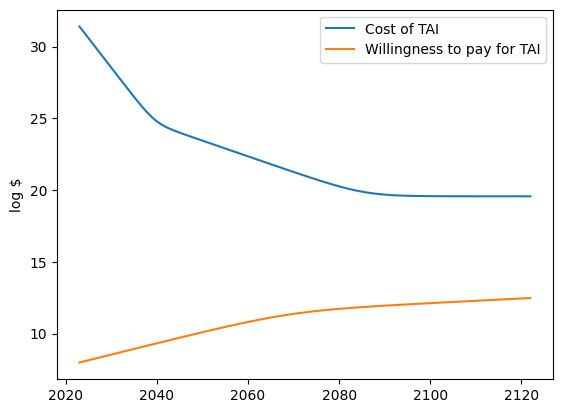

-
-
## SAMPLE RUN 3 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (599 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.4 (232 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (961 septillion) available

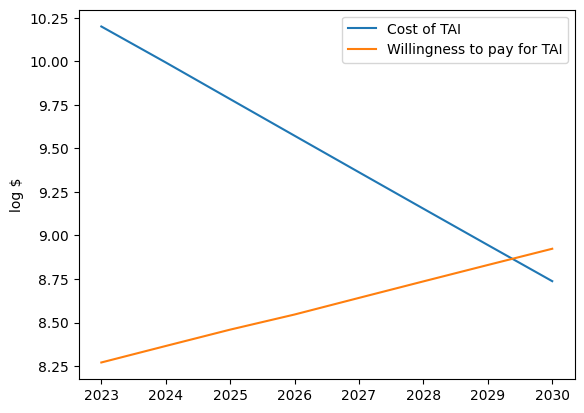

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|██████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.35it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2918.39it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2034',
 '20%: 2035',
 '25%: 2037',
 '35%: 2039',
 '50%: 2045',
 '60%: 2050',
 '75%: 2074',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 8 years from now',
 '10%: 10 years from now',
 '15%: 11 years from now',
 '20%: 12 years from now',
 '25%: 14 years from now',
 '35%: 16 years from now',
 '50%: 22 years from now',
 '60%: 27 years from now',
 '75%: 51 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 1.9%
2030-2034: 14.8%
2035-2039: 19.5%
2040-2049: 22.2%
2050-2059: 10.6%
2060-2069: 4.8%
2070-2079: 1.9%
2080-2089: 0.9%
2090-2099: 0.5%
2100-2109: 0.8%
2110-2119: 0.5%
>2120: 21.4%
-
-


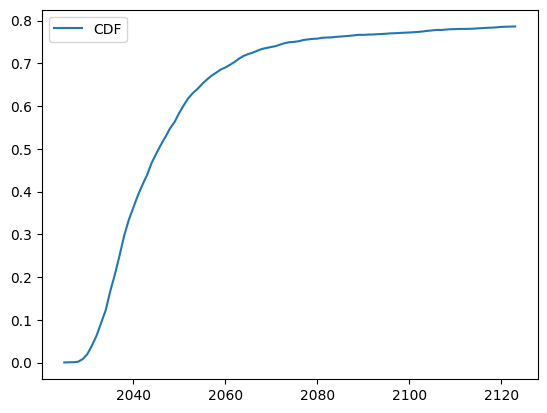

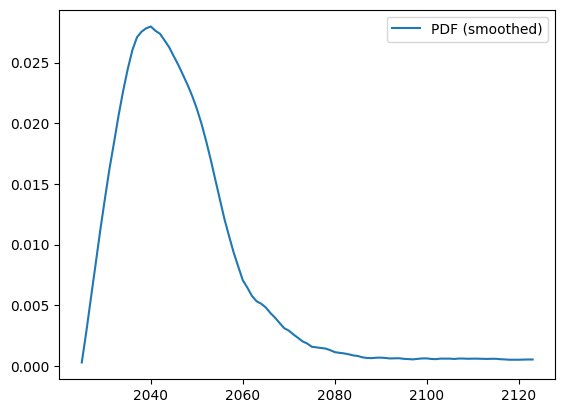

-
-
## TAI FLOP SIZE ##
{1: 25.0,
 5: 26.2,
 10: 26.9,
 20: 27.7,
 30: 28.6,
 40: 29.6,
 50: 31.4,
 60: 33.6,
 70: 35.8,
 80: 38.1,
 90: 41.2,
 95: 43.9,
 99: 48.6}


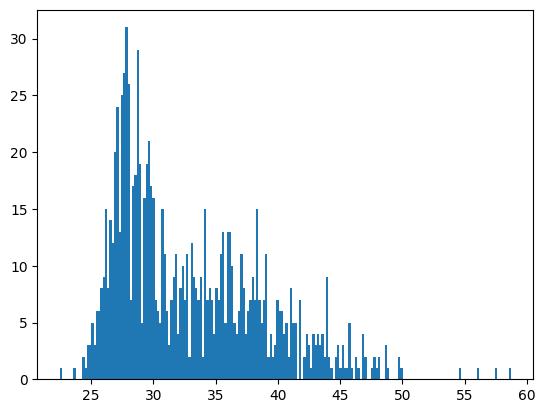

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.5,
 70: 2.4,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}


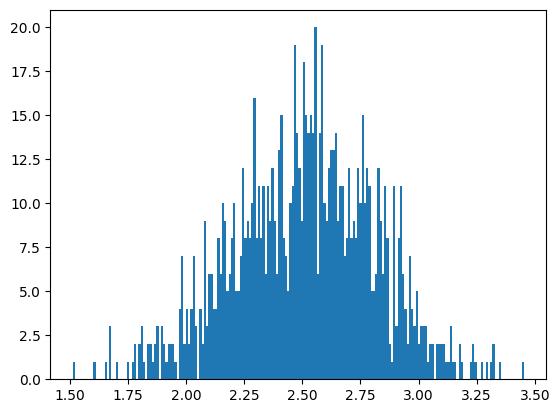

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.5,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.2,
 50: 22.4,
 60: 22.7,
 70: 23.0,
 80: 23.2,
 90: 23.6,
 95: 24.0,
 99: 24.5}


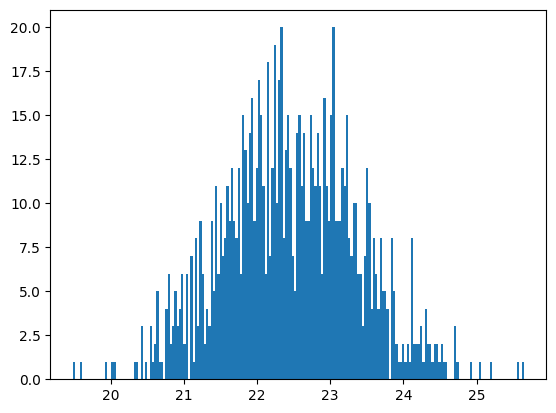

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.4,
 80: 8.6,
 90: 9.0,
 95: 9.2,
 99: 9.8}


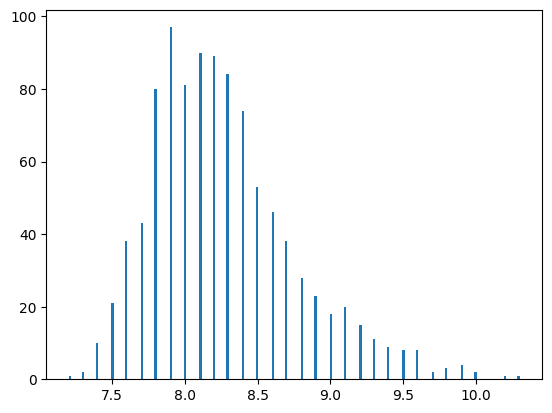

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}


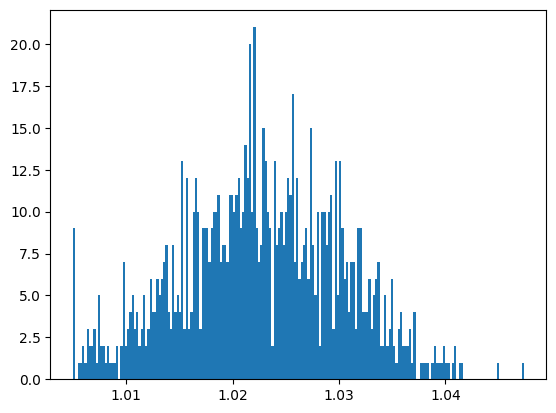

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00033,
 50: 0.00041,
 60: 0.00053,
 70: 0.00071,
 80: 0.00107,
 90: 0.00213,
 95: 0.00376,
 99: 0.00947}


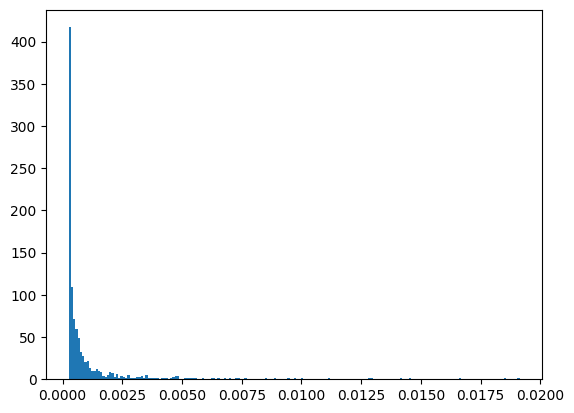

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.2,
 20: 3.7,
 30: 3.4,
 40: 3.2,
 50: 2.9,
 60: 2.7,
 70: 2.5,
 80: 2.2,
 90: 1.8,
 95: 1.6,
 99: 1.0}


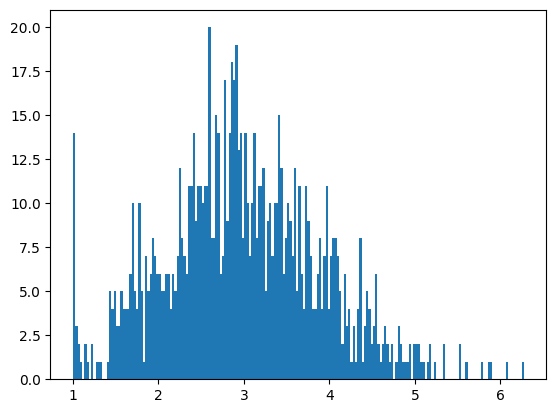

-
-
-
-
## GDP Over Time ##


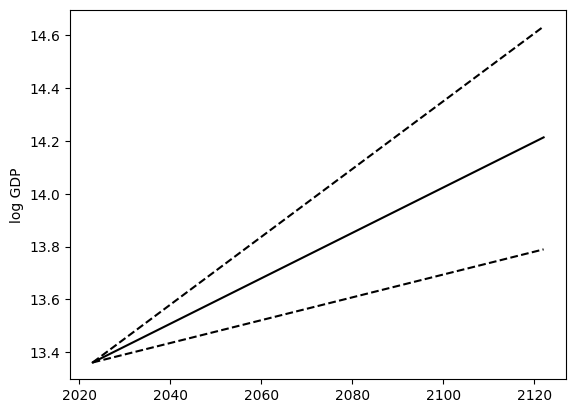

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

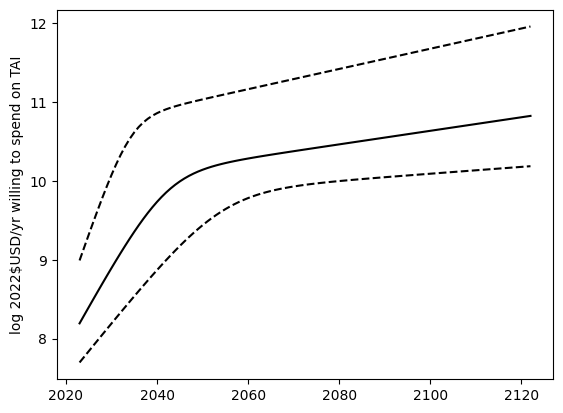

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~50 million) - 9.0 (~980 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~197 million) 90% CI 7.8 (~59 million) - 9.2 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~249 million) 90% CI 7.8 (~69 million) - 9.3 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~314 million) 90% CI 7.9 (~81 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~396 million) 90% CI 8.0 (~95 million) - 9.6 (~4 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~499 million) 90% CI 8.1 (~112 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~626 million) 90% CI 8.1 (~132 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~783 million) 90% CI 8.2 (~155 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~978 million) 90% CI 8.3 (~182 million) - 10.2 (~16 billion)


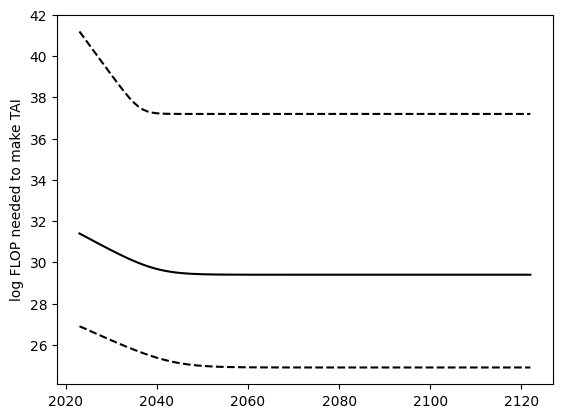

Year: 2023 - log FLOP needed for TAI 31.4 (~25 nonillion) 90% CI 26.9 (~794 septillion) - 41.2 (~158 million decillion)
Year: 2024 - log FLOP needed for TAI 31.3 (~19 nonillion) 90% CI 26.8 (~638 septillion) - 40.9 (~79 million decillion)
Year: 2025 - log FLOP needed for TAI 31.2 (~15 nonillion) 90% CI 26.7 (~508 septillion) - 40.6 (~40 million decillion)
Year: 2026 - log FLOP needed for TAI 31.0 (~11 nonillion) 90% CI 26.6 (~405 septillion) - 40.3 (~20 million decillion)
Year: 2027 - log FLOP needed for TAI 30.9 (~9 nonillion) 90% CI 26.5 (~323 septillion) - 40.0 (~10 million decillion)
Year: 2028 - log FLOP needed for TAI 30.8 (~7 nonillion) 90% CI 26.4 (~258 septillion) - 39.7 (~5 million decillion)
Year: 2029 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 26.3 (~207 septillion) - 39.4 (~2 million decillion)
Year: 2030 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.2 (~166 septillion) - 39.1 (~1 million decillion)
Year: 2031 - log FLOP needed for TAI 30.5 (~3 nonillio

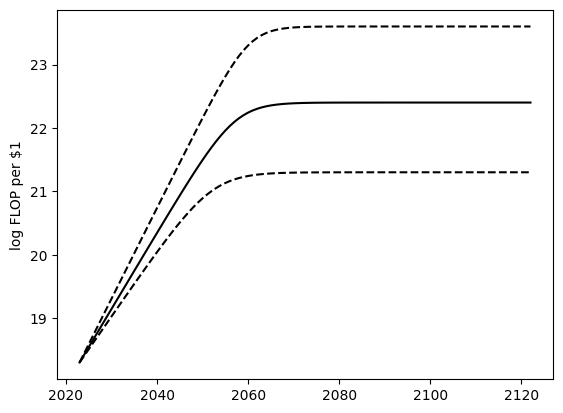

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

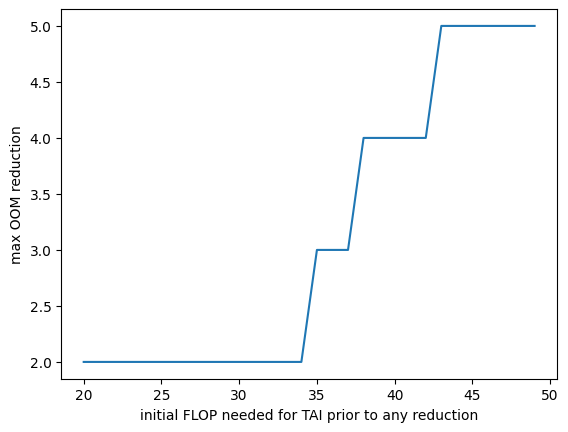

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

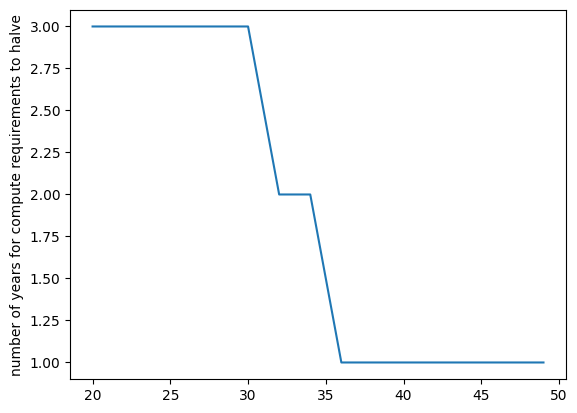

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

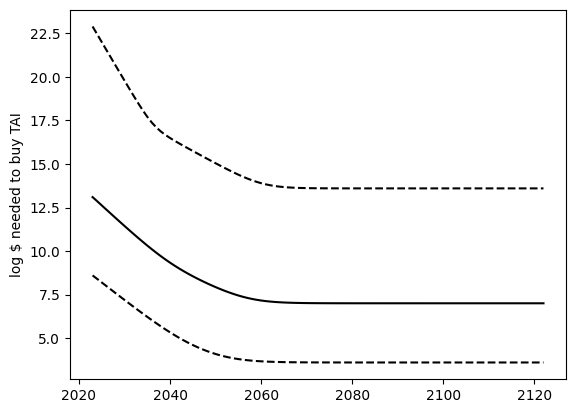

Year: 2023 - 13.1 log 2022$USD to buy TAI (~13 trillion) 90% CI 8.6 (~399 million) - 22.9 (~79 sextillion)
Year: 2024 - 12.9 log 2022$USD to buy TAI (~7 trillion) 90% CI 8.4 (~252 million) - 22.5 (~29 sextillion)
Year: 2025 - 12.6 log 2022$USD to buy TAI (~4 trillion) 90% CI 8.2 (~158 million) - 22.0 (~10 sextillion)
Year: 2026 - 12.4 log 2022$USD to buy TAI (~2 trillion) 90% CI 8.0 (~99 million) - 21.6 (~4 sextillion)
Year: 2027 - 12.1 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.8 (~62 million) - 21.1 (~1 sextillion)
Year: 2028 - 11.9 log 2022$USD to buy TAI (~819 billion) 90% CI 7.6 (~39 million) - 20.7 (~478 quintillion)
Year: 2029 - 11.7 log 2022$USD to buy TAI (~476 billion) 90% CI 7.4 (~25 million) - 20.2 (~172 quintillion)
Year: 2030 - 11.4 log 2022$USD to buy TAI (~278 billion) 90% CI 7.2 (~16 million) - 19.8 (~62 quintillion)
Year: 2031 - 11.2 log 2022$USD to buy TAI (~163 billion) 90% CI 7.0 (~10 million) - 19.4 (~23 quintillion)
Year: 2032 - 11.0 log 2022$USD to buy TAI (

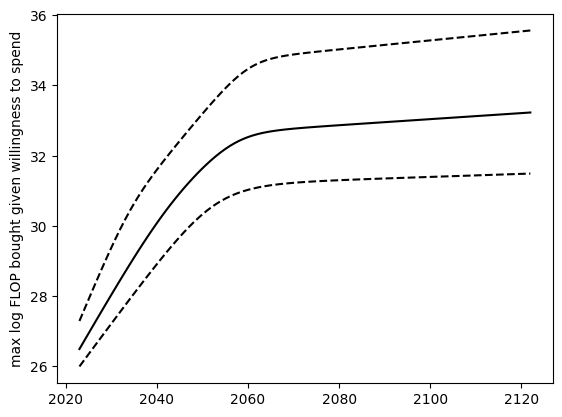

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~99 septillion) - 27.3 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~519 septillion) 90% CI 26.2 (~148 septillion) - 27.6 (~4 octillion)
Year: 2025 - max log FLOP 26.9 (~865 septillion) 90% CI 26.3 (~221 septillion) - 27.9 (~8 octillion)
Year: 2026 - max log FLOP 27.2 (~1 octillion) 90% CI 26.5 (~331 septillion) - 28.2 (~16 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~494 septillion) - 28.5 (~32 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~738 septillion) - 28.8 (~64 octillion)
Year: 2029 - max log FLOP 27.8 (~7 octillion) 90% CI 27.0 (~1 octillion) - 29.1 (~124 octillion)
Year: 2030 - max log FLOP 28.0 (~11 octillion) 90% CI 27.2 (~2 octillion) - 29.4 (~239 octillion)
Year: 2031 - max log FLOP 28.3 (~18 octillion) 90% CI 27.4 (~2 octillion) - 29.7 (~451 octillion)
Year: 2032 - max log FLOP 28.5 (~29 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~830 octillion)
Year: 2033

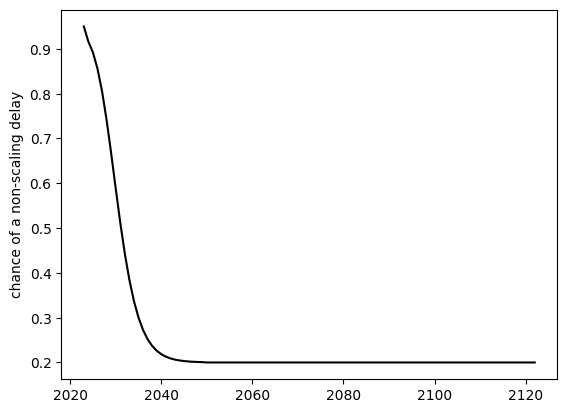

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 86%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 67%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2033

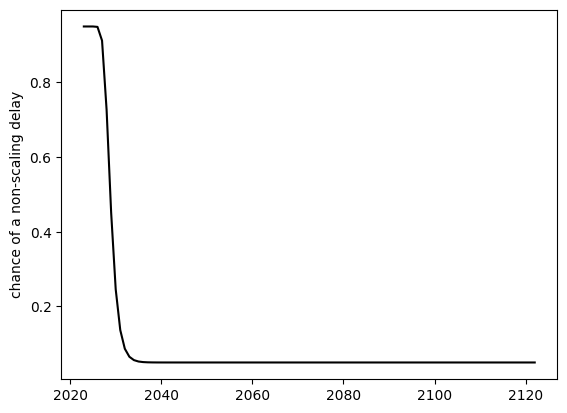

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 73%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2033 

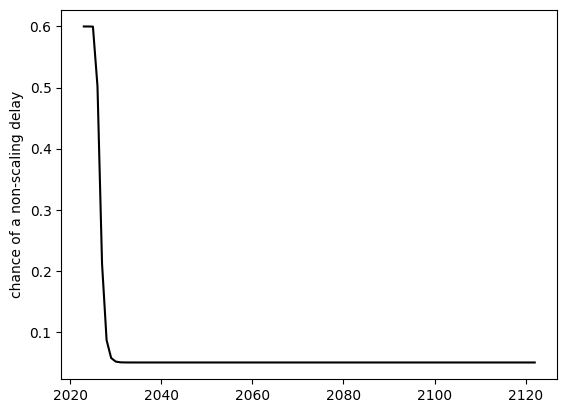

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

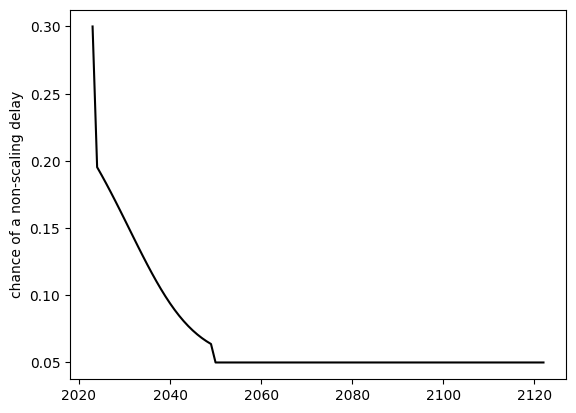

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033

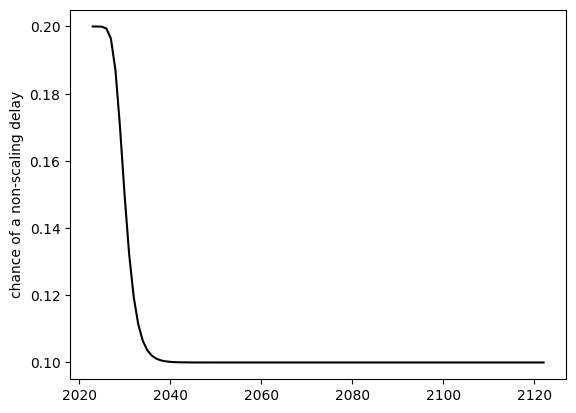

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033

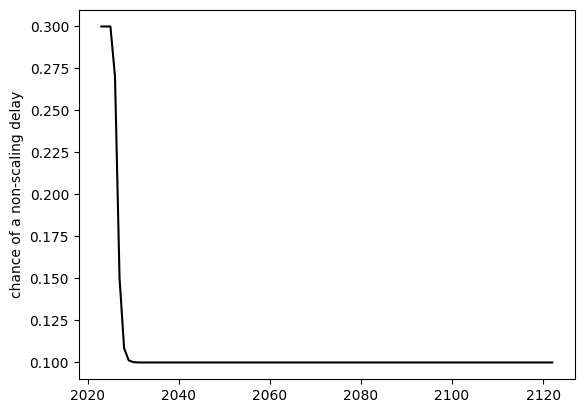

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

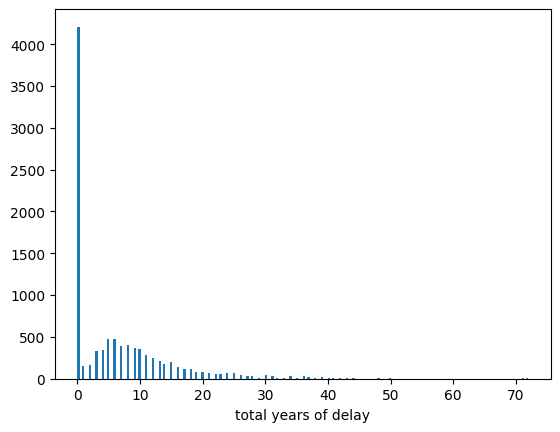

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 41.6 log FLOP (~398 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 3.7 years to a max of 0.027041% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 41.6 log FLOP (398 million decillion) - log $ 23.3 to buy TAI (200 sextillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (209 septillion) available - TAI takes 41.3 log FLOP (199 million decillion) - log $ 22.9 to buy TAI (71 sextillion) vs. willingness to pay log $ 7.9 (75 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log 

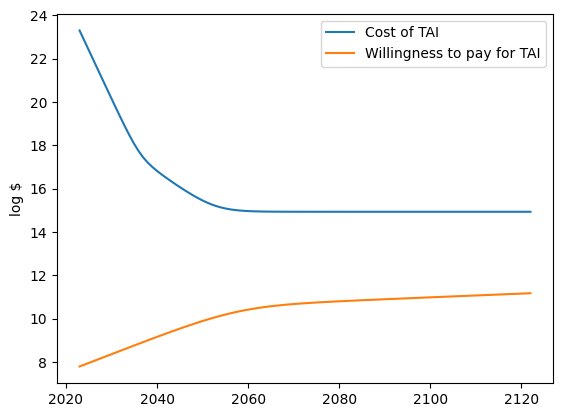

-
-
## SAMPLE RUN 5 ##
It takes 35.1 log FLOP (~126 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 3.3 years to a max of 0.059085% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.5 max log FLOP (309 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.8 to buy TAI (63 quadrillion) vs. willingness to pay log $ 8.2 (155 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (472 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 8.3 (190 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 26.9 max log FLOP (722 septilli

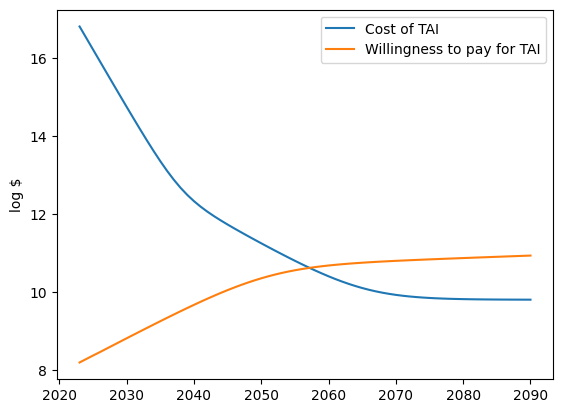

-
-
## SAMPLE RUN 6 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.0 max log FLOP (98 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (151 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 7.8 (60 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (233 septillion) available - TAI takes 27

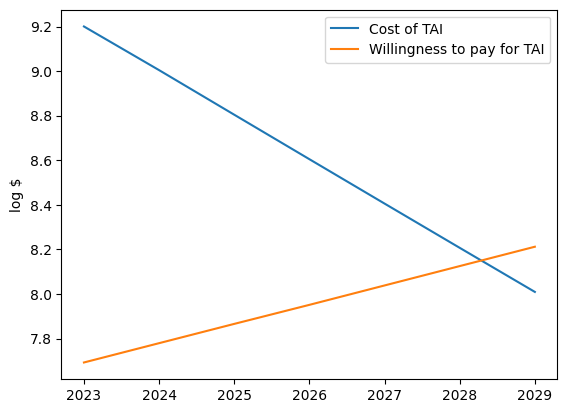

-
-
## SAMPLE RUN 7 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~105 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~393 million). This doubles every 3.8 years to a max of 0.131717% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.9 max log FLOP (774 septillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.6 (388 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 13 years)
-- robotics p_nonscaling_issue p=0.6 -> Non

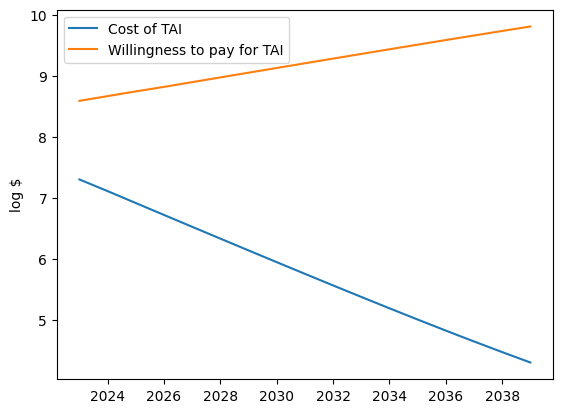

-
-
## SAMPLE RUN 8 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 33.9 log FLOP (7 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.9 (769 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available - T

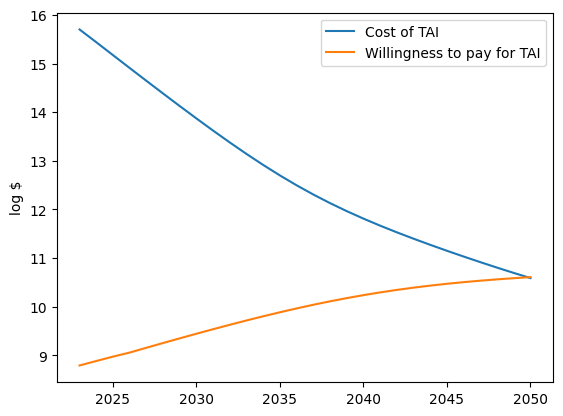

-
-
## SAMPLE RUN 9 ##
It takes 25.4 log FLOP (~25 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 25.4 log FLOP (25 septillion) - log $ 7.1 to buy TAI (13 million) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 8 years)
-- robotics p_nonscaling_issue p=0.6 -> Nonscalin

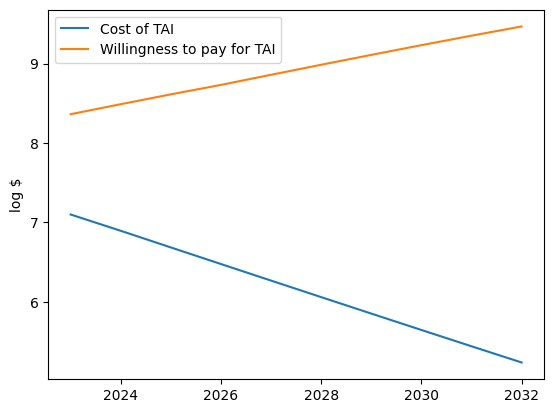

-
-
## SAMPLE RUN 10 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~753 million). This doubles every 3.9 years to a max of 0.063213% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.6 to buy TAI (40 sextillion) vs. willingness to pay log $ 8.9 (716 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.2 to buy TAI (15 sextillion) vs. willingness to pay log $ 8.9 (847 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLOP 

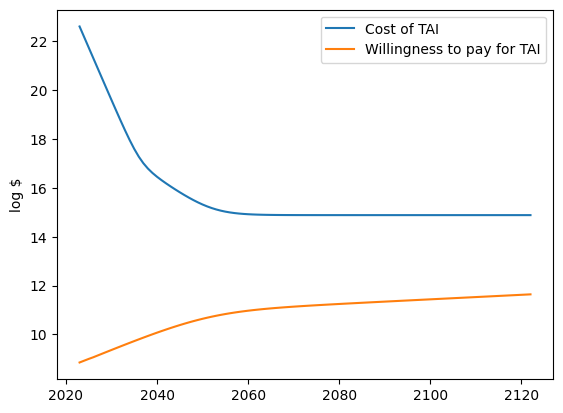

-
-
## SAMPLE RUN 11 ##
It takes 30.0 log FLOP (~1 nonillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 4.0 years to a max of 0.086688% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 30.0 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (501 billion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (370 septillion) available - TAI takes 29.9 log FLOP (804 octillion) - log $ 11.5 to buy TAI (321 billion) vs. willingness to pay log $ 8.2 (148 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (552 septillion) avai

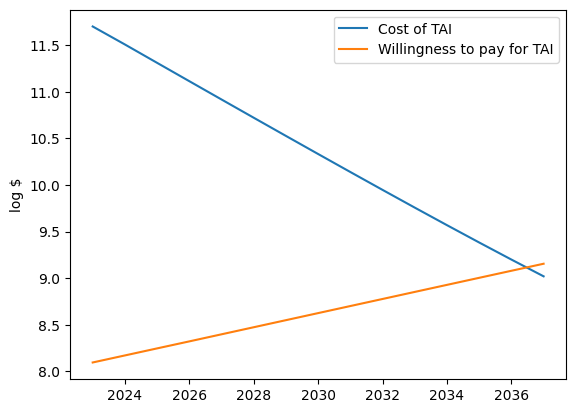

-
-
## SAMPLE RUN 12 ##
It takes 38.0 log FLOP (~100 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~485 million). This doubles every 4.3 years to a max of 0.065231% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.0 max log FLOP (937 septillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.7 to buy TAI (50 quintillion) vs. willingness to pay log $ 8.7 (470 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 37.7 log FLOP (50 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 8.7 (550 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 m

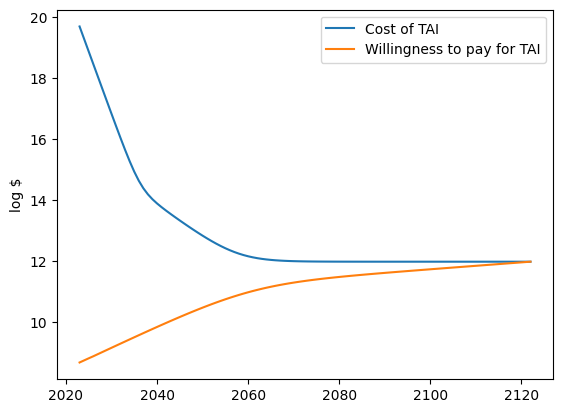

-
-
## SAMPLE RUN 13 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 32.8 log FLOP (631 nonillion) - log $ 14.5 to buy TAI (316 trillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (762 septillion) available - TAI takes 32.7 log FLOP (452 nonillion) - log $ 14.2 to buy TAI (176 trillion) vs. willingness to pay log $ 8.5 (297 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) avail

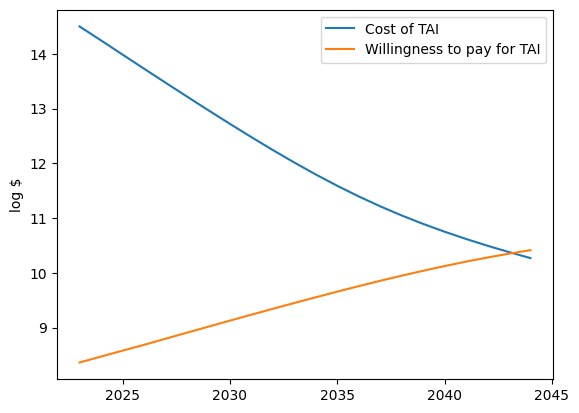

-
-
## SAMPLE RUN 14 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~476 sextillion) per 2022$USD.
We are initially willing to pay 7.4 log 2022$USD (~25 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 25.7 max log FLOP (50 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 7.4 (25 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (90 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.2 to buy TAI (1 billion) vs. willingness to pay log $ 7.5 (33 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.2 max log FLOP (162 septillion) available - TAI takes

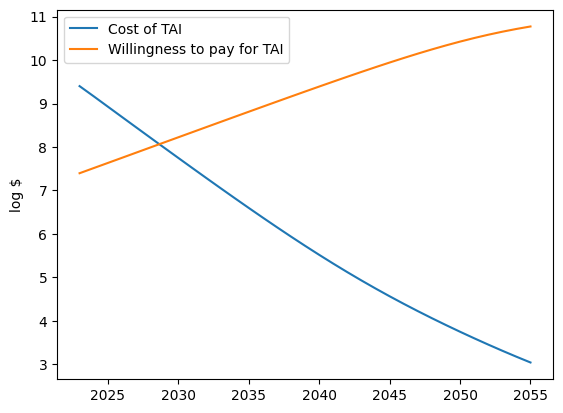

-
-
## SAMPLE RUN 15 ##
It takes 41.0 log FLOP (~100 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~312 million). This doubles every 2.9 years to a max of 0.105514% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.8 max log FLOP (615 septillion) available - TAI takes 41.0 log FLOP (100 million decillion) - log $ 22.7 to buy TAI (50 sextillion) vs. willingness to pay log $ 8.5 (308 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 40.7 log FLOP (50 million decillion) - log $ 22.3 to buy TAI (19 sextillion) vs. willingness to pay log $ 8.6 (389 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log 

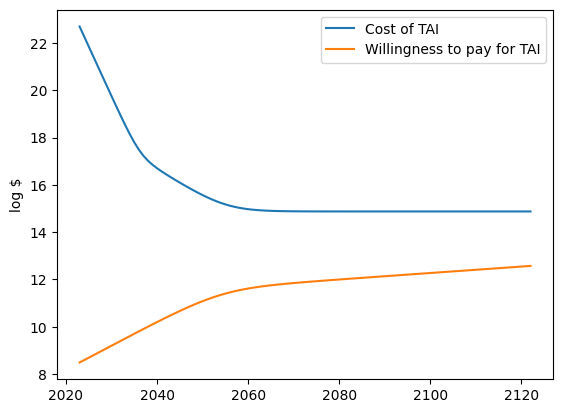

-
-
## SAMPLE RUN 16 ##
It takes 36.3 log FLOP (~2 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~224 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 4.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 36.3 log FLOP (2 thousand decillion) - log $ 18.0 to buy TAI (1 quintillion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (118 septillion) available - TAI takes 36.0 log FLOP (1000 decillion) - log $ 17.6 to buy TAI (393 quadrillion) vs. willingness to pay log $ 7.7 (46 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.2 max log FLOP (17

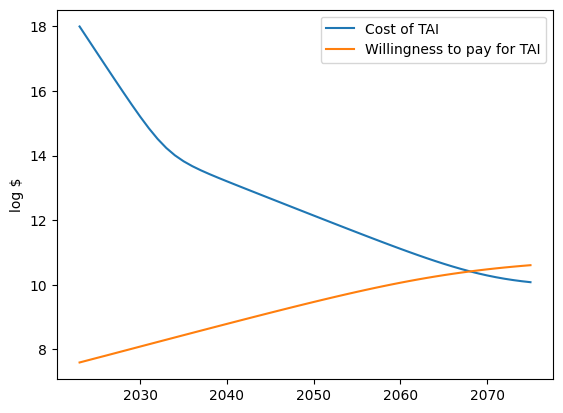

-
-
## SAMPLE RUN 17 ##
It takes 36.2 log FLOP (~2 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~989 quintillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.7 years to a max of 0.03914% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.3 max log FLOP (195 septillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 17.9 to buy TAI (796 quadrillion) vs. willingness to pay log $ 8.0 (98 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (344 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.5 to buy TAI (291 quadrillion) vs. willingness to pay log $ 8.1 (126 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log F

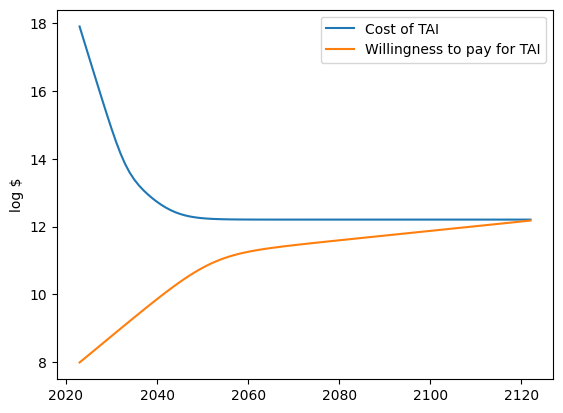

-
-
## SAMPLE RUN 18 ##
It takes 36.9 log FLOP (~8 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~147 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.6 to buy TAI (4 quintillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.2 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.6 (427 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FL

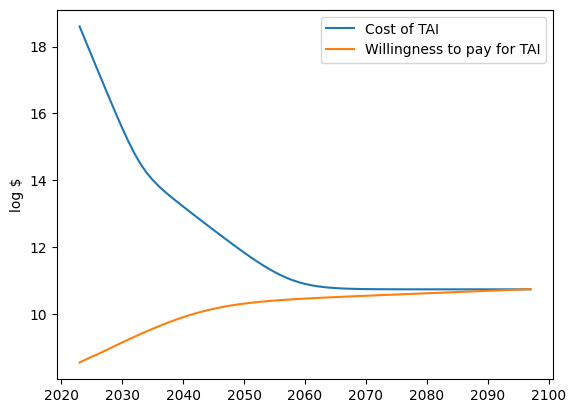

-
-
## SAMPLE RUN 19 ##
It takes 35.1 log FLOP (~126 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 20.0 log FLOP (~93 quintillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.9 years to a max of 0.142311% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.8 to buy TAI (64 quadrillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (126 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.5 to buy TAI (30 quadrillion) vs. willingness to pay log $ 7.7 (47 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (203 septillion

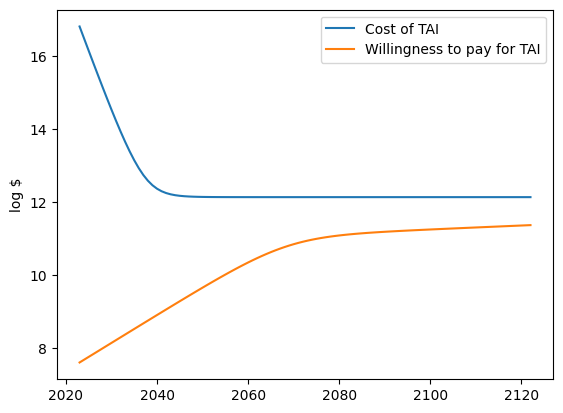

-
-
## SAMPLE RUN 20 ##
It takes 42.6 log FLOP (~4 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~379 million). This doubles every 1 years to a max of 0.033713% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.9 max log FLOP (720 septillion) available - TAI takes 42.6 log FLOP (4 billion decillion) - log $ 24.3 to buy TAI (2 septillion) vs. willingness to pay log $ 8.6 (361 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 42.3 log FLOP (2 billion decillion) - log $ 23.8 to buy TAI (699 sextillion) vs. willingness to pay log $ 8.8 (692 million) - 18.5 log FLOP per $ (3 quintillion)
Year: 2025 - 27.7 max log FLOP (5 

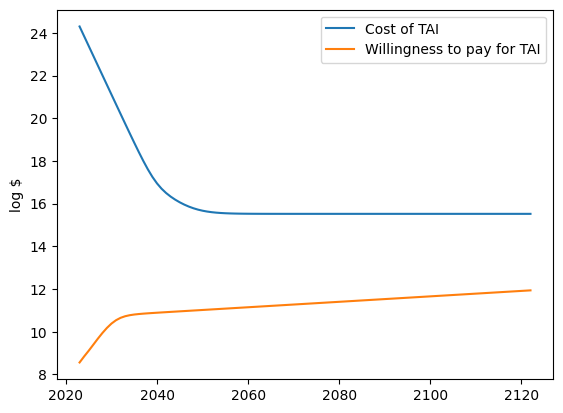

-
-
## SAMPLE RUN 21 ##
It takes 31.9 log FLOP (~79 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~146 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 3.6 years to a max of 2.176301% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 31.9 log FLOP (79 nonillion) - log $ 13.6 to buy TAI (40 trillion) vs. willingness to pay log $ 7.5 (32 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (105 septillion) available - TAI takes 31.8 log FLOP (61 nonillion) - log $ 13.3 to buy TAI (22 trillion) vs. willingness to pay log $ 7.6 (38 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.2 max log FLOP (176 septillion) availa

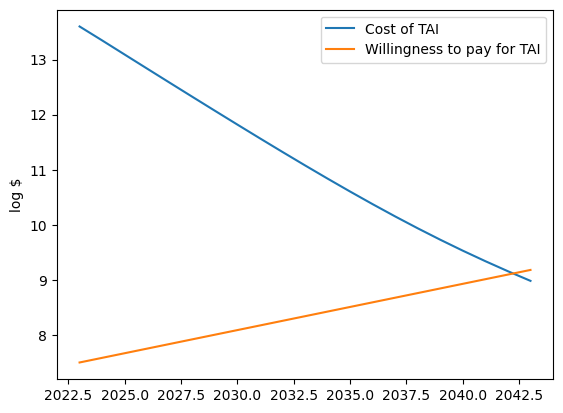

-
-
## SAMPLE RUN 22 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~194 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.0 years to a max of 0.071389% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (367 septillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.4 to buy TAI (242 million) vs. willingness to pay log $ 8.1 (139 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (681 septillion) av

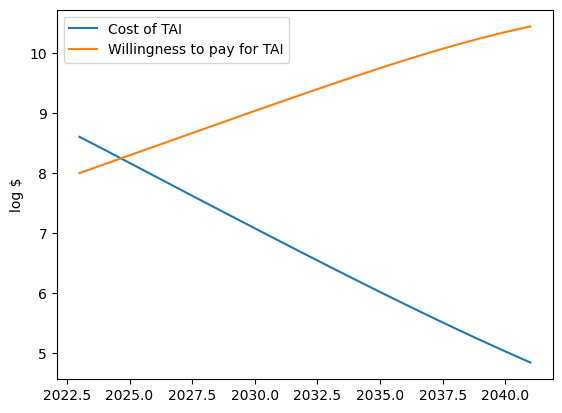

-
-
## SAMPLE RUN 23 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (125 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 7.7 (48 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (199 septillion) available - T

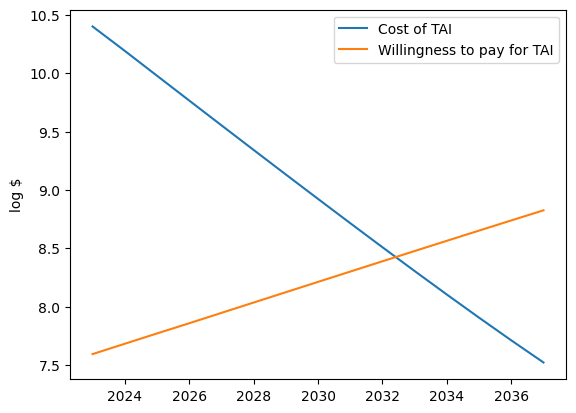

-
-
## SAMPLE RUN 24 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.0 years to a max of 0.044366% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (257 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (973 million) vs. willingness to pay log $ 8.0 (98 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (424 septillion) available - TAI

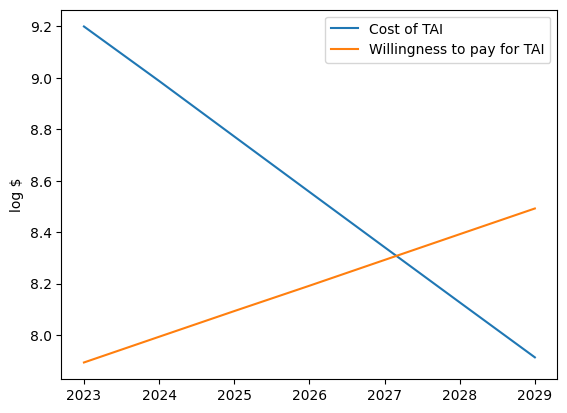

-
-
## SAMPLE RUN 25 ##
It takes 49.5 log FLOP (~32 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~99 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 49.5 log FLOP (32 quadrillion decillion) - log $ 31.2 to buy TAI (16 nonillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (743 septillion) available - TAI takes 49.2 log FLOP (16 quadrillion decillion) - log $ 30.8 to buy TAI (6 nonillion) vs. willingness to pay log $ 8.5 (294 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 m

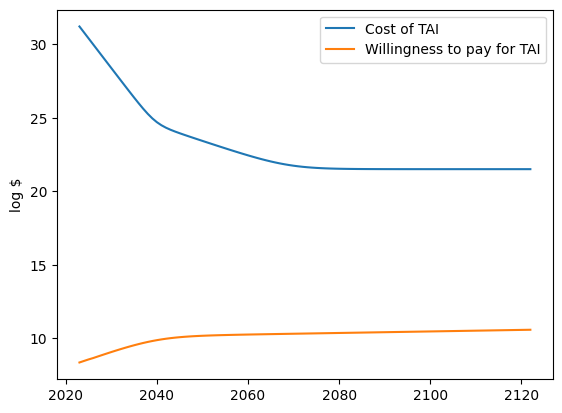

-
-
## SAMPLE RUN 26 ##
It takes 45.3 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~439 quintillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.4 years to a max of 0.865006% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.5 max log FLOP (314 septillion) available - TAI takes 45.3 log FLOP (2 trillion decillion) - log $ 27.0 to buy TAI (1 octillion) vs. willingness to pay log $ 8.2 (158 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (538 septillion) available - TAI takes 45.0 log FLOP (998 billion decillion) - log $ 26.6 to buy TAI (391 septillion) vs. willingness to pay log $ 8.3 (211 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max l

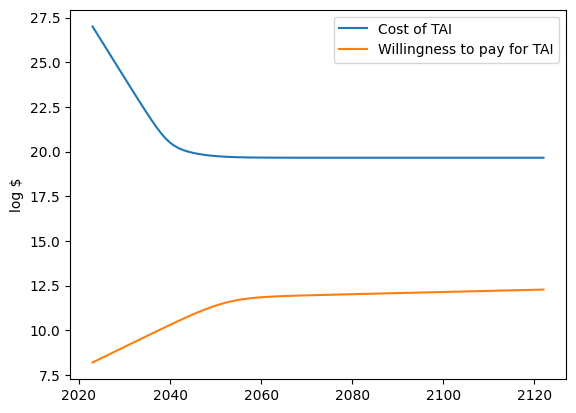

-
-
## SAMPLE RUN 27 ##
It takes 29.8 log FLOP (~631 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~365 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 3.7 years to a max of 0.236884% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.9 max log FLOP (783 septillion) available - TAI takes 29.8 log FLOP (631 octillion) - log $ 11.5 to buy TAI (316 billion) vs. willingness to pay log $ 8.6 (392 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.7 log FLOP (507 octillion) - log $ 11.3 to buy TAI (189 billion) vs. willingness to pay log $ 8.7 (473 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 octillion) avail

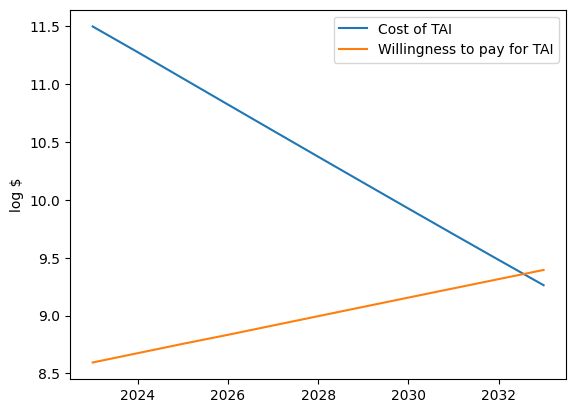

-
-
## SAMPLE RUN 28 ##
It takes 35.9 log FLOP (~794 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~40 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 3.2 years to a max of 0.173799% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.7 max log FLOP (495 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.6 to buy TAI (398 quadrillion) vs. willingness to pay log $ 8.4 (248 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (827 septillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.3 to buy TAI (187 quadrillion) vs. willingness to pay log $ 8.5 (309 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octill

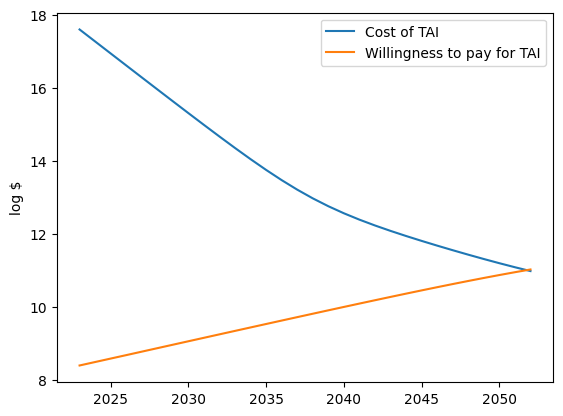

-
-
## SAMPLE RUN 29 ##
It takes 46.1 log FLOP (~13 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~265 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 1 years to a max of 0.044382% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 46.1 log FLOP (13 trillion decillion) - log $ 27.8 to buy TAI (6 octillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (329 septillion) available - TAI takes 45.8 log FLOP (6 trillion decillion) - log $ 27.4 to buy TAI (2 octillion) vs. willingness to pay log $ 8.1 (124 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP

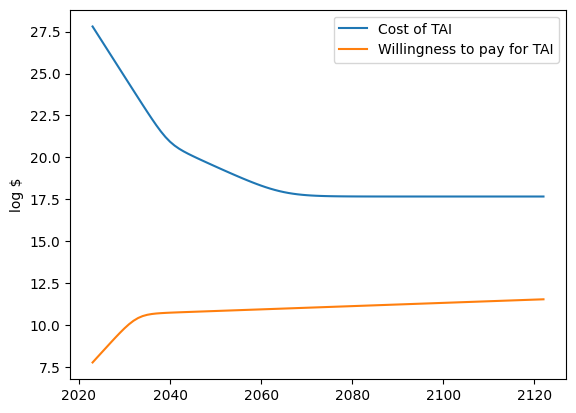

-
-
## SAMPLE RUN 30 ##
It takes 32.3 log FLOP (~200 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~27 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 3.2 years to a max of 0.047489% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.5 max log FLOP (307 septillion) available - TAI takes 32.3 log FLOP (200 nonillion) - log $ 14.0 to buy TAI (100 trillion) vs. willingness to pay log $ 8.2 (154 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (518 septillion) available - TAI takes 32.2 log FLOP (143 nonillion) - log $ 13.7 to buy TAI (53 trillion) vs. willingness to pay log $ 8.3 (190 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (874 septillion)

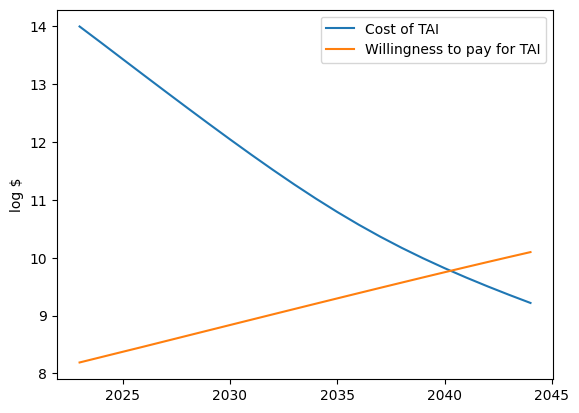

-
-
## SAMPLE RUN 31 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~62 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 3.7 years to a max of 0.034408% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.4 max log FLOP (243 septillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (400 septillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.4 to buy TAI (23 billion) vs. willingness to pay log $ 8.2 (147 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (656 septillion) avail

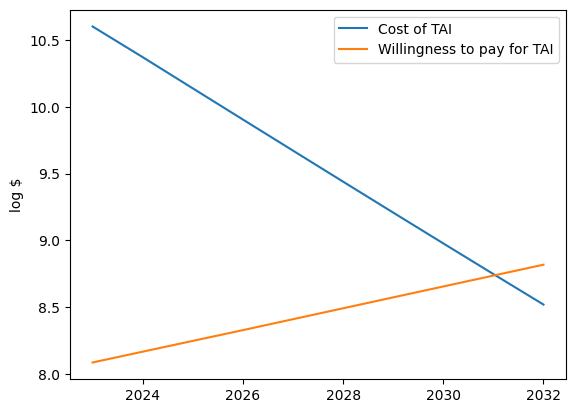

-
-
## SAMPLE RUN 32 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.4 to buy TAI (3 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (958 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.2 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (364 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available - TA

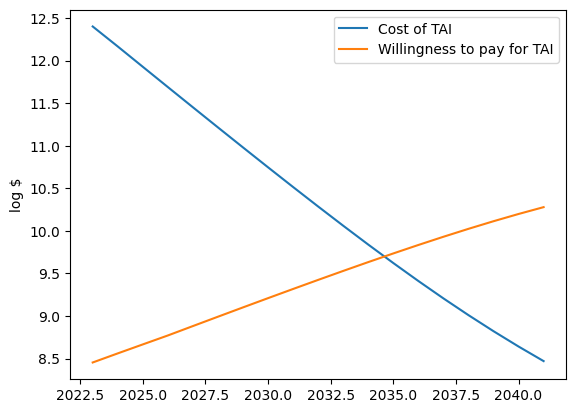

-
-
## SAMPLE RUN 33 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~55 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (201 septillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (61 quadrillion) vs. willingness to pay log $ 7.9 (77 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (327 septillion) 

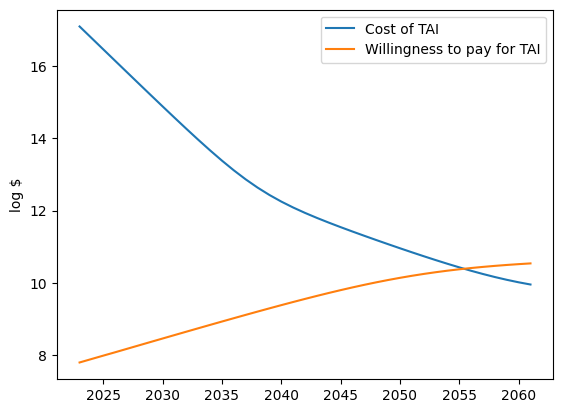

-
-
## SAMPLE RUN 34 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 4.4 years to a max of 0.075162% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (389 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (794 million) vs. willingness to pay log $ 8.3 (195 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (608 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (478 million) vs. willingness to pay log $ 8.4 (228 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (948 septillion) available 

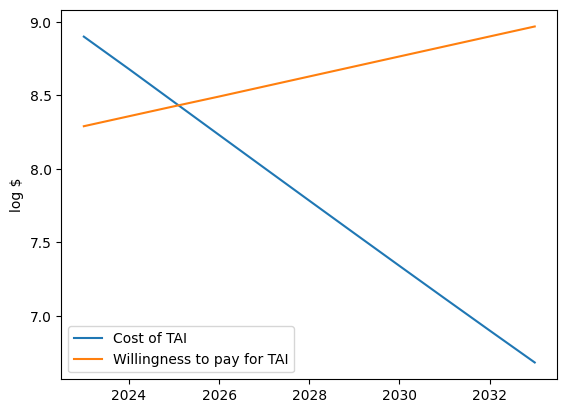

-
-
## SAMPLE RUN 35 ##
It takes 57.0 log FLOP (~1 septillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~93 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 2.3 years to a max of 0.029667% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 57.0 log FLOP (1 septillion decillion) - log $ 38.7 to buy TAI (501 thousand decillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 56.7 log FLOP (500 sextillion decillion) - log $ 38.3 to buy TAI (185 thousand decillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 

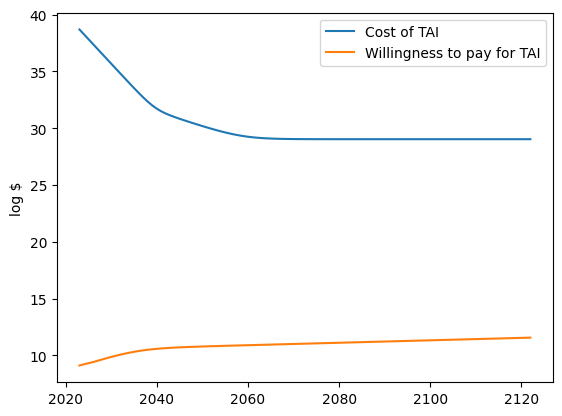

-
-
## SAMPLE RUN 36 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~106 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.042x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (345 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.1 (132 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (616 septillion) available - T

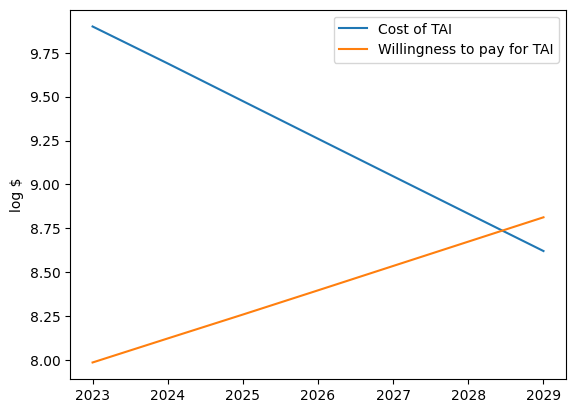

-
-
## SAMPLE RUN 37 ##
It takes 30.8 log FLOP (~6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~238 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 2.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (265 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.0 (104 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (456 septillion) available - 

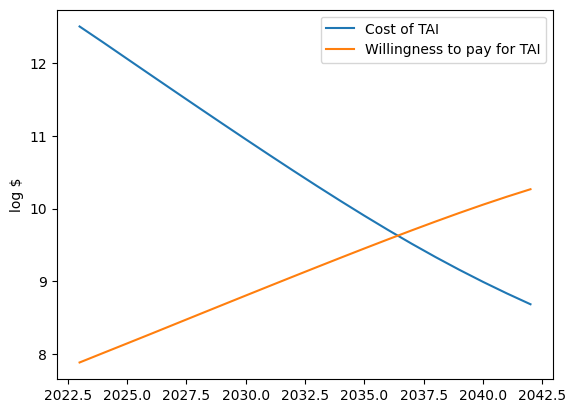

-
-
## SAMPLE RUN 38 ##
It takes 37.6 log FLOP (~40 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 2.6 years to a max of 0.186104% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 37.6 log FLOP (40 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (439 septillion) available - TAI takes 37.3 log FLOP (20 thousand decillion) - log $ 18.9 to buy TAI (7 quintillion) vs. willingness to pay log $ 8.2 (163 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 ma

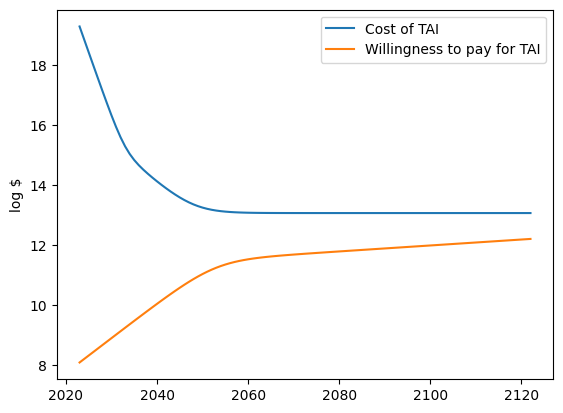

-
-
## SAMPLE RUN 39 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~84 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~374 million). This doubles every 2.7 years to a max of 0.026815% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.8 max log FLOP (703 septillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 8.5 (353 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.7 (448 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 octillion) available -

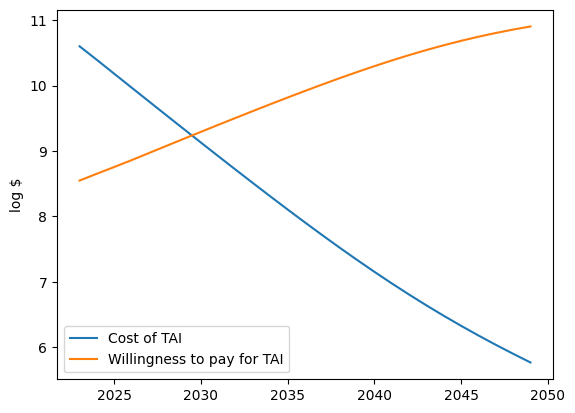

-
-
## SAMPLE RUN 40 ##
It takes 36.4 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.4 years to a max of 0.062946% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.4 max log FLOP (247 septillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (409 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.7 to buy TAI (466 quadrillion) vs. willingness to pay log $ 8.2 (151 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max 

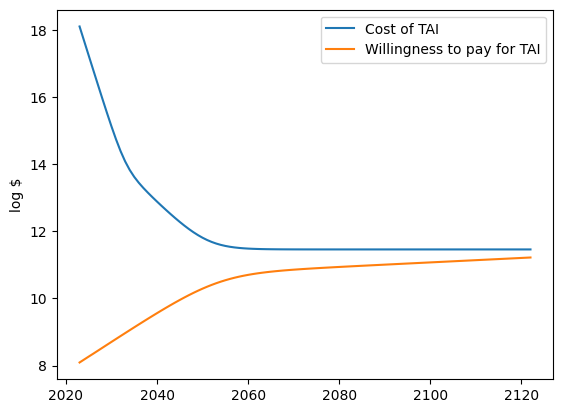

-
-
## SAMPLE RUN 41 ##
It takes 33.1 log FLOP (~1 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~488 million). This doubles every 4.3 years to a max of 0.079368% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.0 max log FLOP (947 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.8 to buy TAI (631 trillion) vs. willingness to pay log $ 8.7 (475 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.0 log FLOP (903 nonillion) - log $ 14.5 to buy TAI (312 trillion) vs. willingness to pay log $ 8.7 (556 million) - 18.5 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (3 octillion) available

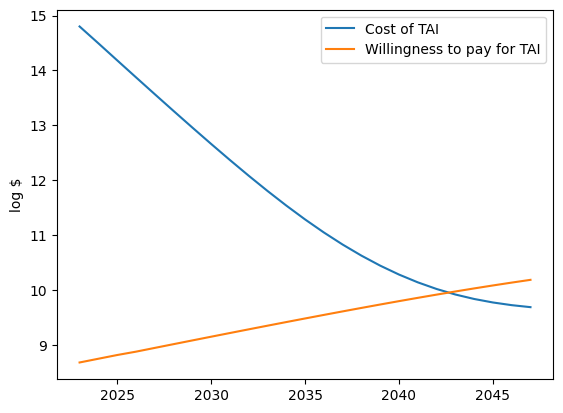

-
-
## SAMPLE RUN 42 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~118 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (415 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 8.2 (164 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (716 septillion) available 

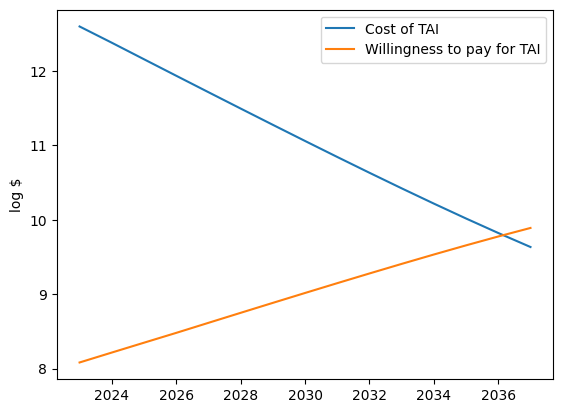

-
-
## SAMPLE RUN 43 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.5 years to a max of 0.030434% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.3 max log FLOP (194 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (340 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (9 quadrillion) vs. willingness to pay log $ 8.1 (128 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (595 septillion) a

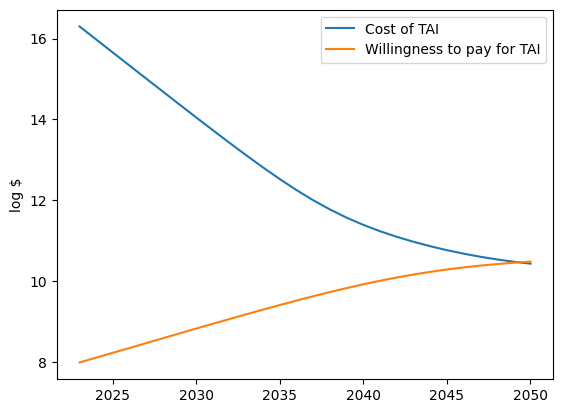

-
-
## SAMPLE RUN 44 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.4 years to a max of 0.046585% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (256 septillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.0 (96 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log 

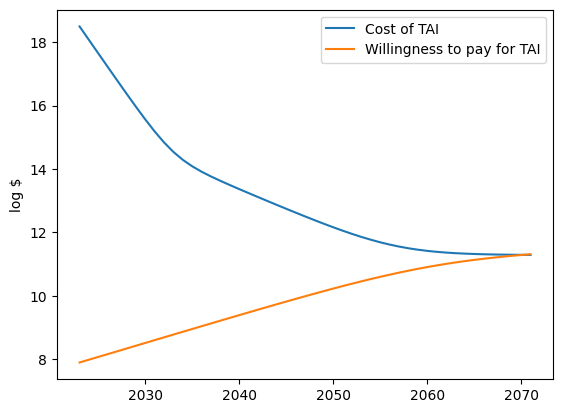

-
-
## SAMPLE RUN 45 ##
It takes 39.6 log FLOP (~4 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 4.3 years to a max of 0.117931% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 39.6 log FLOP (4 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (121 septillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (771 quintillion) vs. willingness to pay log $ 7.7 (47 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP 

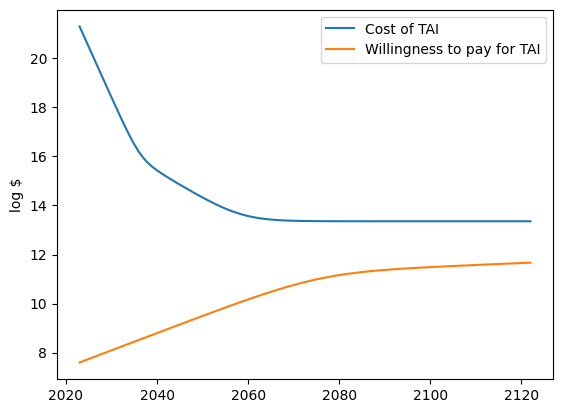

-
-
## SAMPLE RUN 46 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (316 quintillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (262 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.1 to buy TAI (123 quintillion) vs. willingness to pay log $ 8.0 (102 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 ma

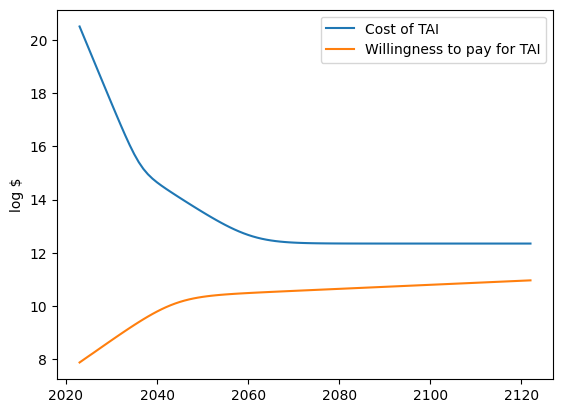

-
-
## SAMPLE RUN 47 ##
It takes 30.0 log FLOP (~1 nonillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.4 max log FLOP (240 septillion) available - TAI takes 30.0 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (502 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (501 septillion) available - TAI takes 29.9 log FLOP (804 octillion) - log $ 11.5 to buy TAI (303 billion) vs. willingness to pay log $ 8.3 (189 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (1 octillion) available -

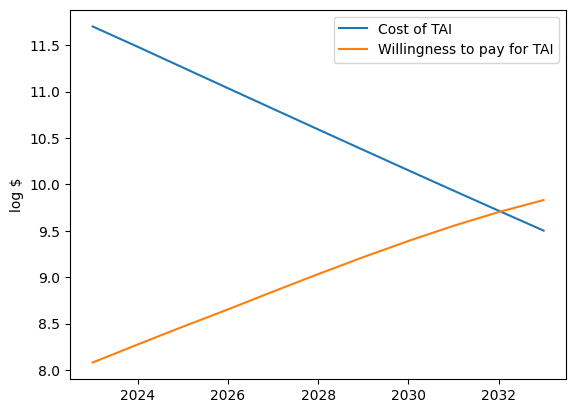

-
-
## SAMPLE RUN 48 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~256 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~990 million). This doubles every 3.2 years to a max of 0.449721% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.3 to buy TAI (200 million) vs. willingness to pay log $ 9.0 (981 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 6 years)
-- robotics p_nonscaling_issue p=0.6 -> Nons

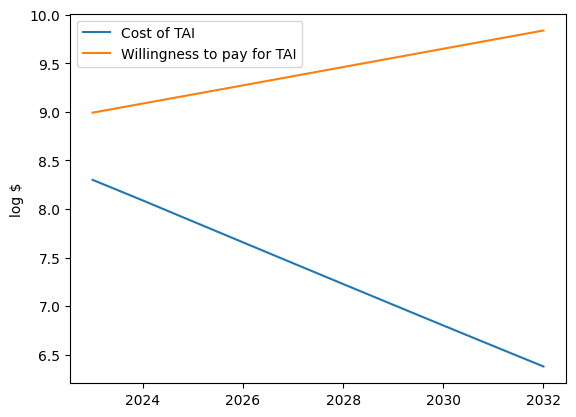

-
-
## SAMPLE RUN 49 ##
It takes 45.0 log FLOP (~1 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 3.6 years to a max of 0.143757% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.6 max log FLOP (393 septillion) available - TAI takes 45.0 log FLOP (1 trillion decillion) - log $ 26.7 to buy TAI (501 septillion) vs. willingness to pay log $ 8.3 (197 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (692 septillion) available - TAI takes 44.7 log FLOP (500 billion decillion) - log $ 26.2 to buy TAI (173 septillion) vs. willingness to pay log $ 8.4 (239 million) - 18.5 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max l

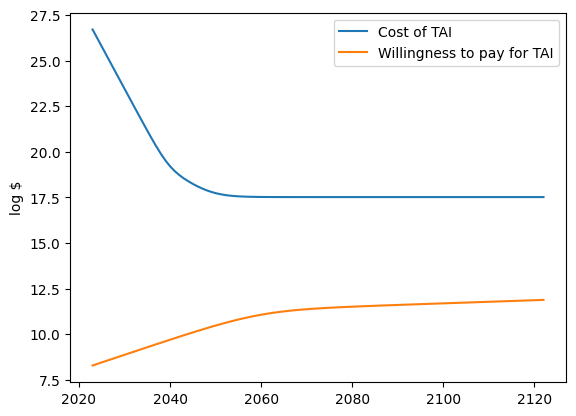

-
-
## SAMPLE RUN 50 ##
It takes 29.8 log FLOP (~631 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 29.8 log FLOP (631 octillion) - log $ 11.5 to buy TAI (316 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (509 septillion) available - TAI takes 29.7 log FLOP (507 octillion) - log $ 11.3 to buy TAI (187 billion) vs. willingness to pay log $ 8.3 (188 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (864 septillion) avai

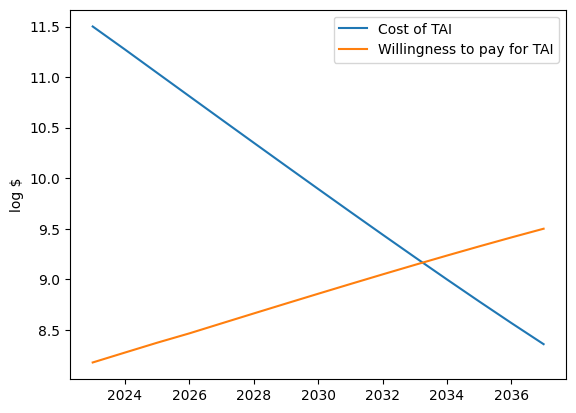

-
-
## SAMPLE RUN 51 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~115 sextillion) per 2022$USD.
We are initially willing to pay 9.5 log 2022$USD (~3 billion). This doubles every 4.3 years to a max of 0.071001% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 9.4 (3 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 9.5 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.9161 -> Nonscaling delay occured
-- 

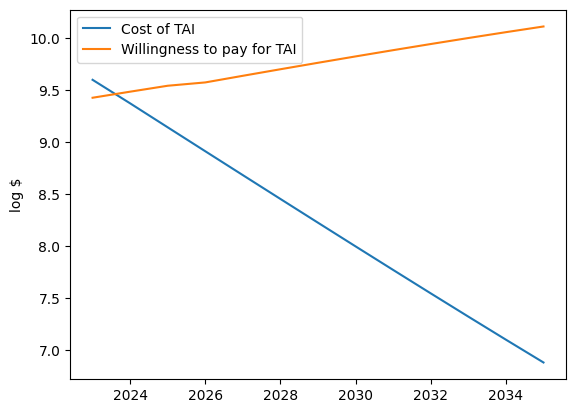

-
-
## SAMPLE RUN 52 ##
It takes 39.1 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.2 years to a max of 0.025959% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.7 max log FLOP (462 septillion) available - TAI takes 39.1 log FLOP (1 million decillion) - log $ 20.8 to buy TAI (631 quintillion) vs. willingness to pay log $ 8.4 (232 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (796 septillion) available - TAI takes 38.8 log FLOP (630 thousand decillion) - log $ 20.4 to buy TAI (225 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max

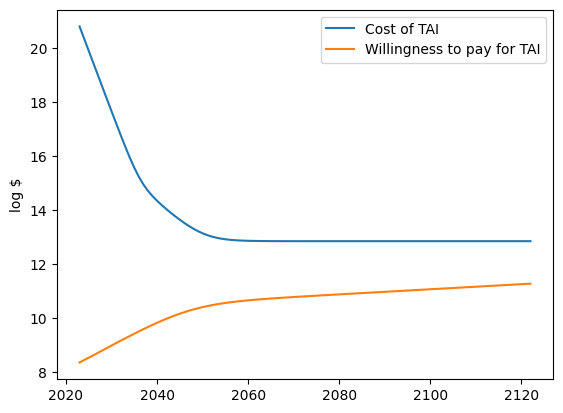

-
-
## SAMPLE RUN 53 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~34 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 4.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 26.7 log FLOP (501 septillion) - log $ 8.4 to buy TAI (251 million) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (441 septillion) available - TAI takes 26.6 log FLOP (403 septillion) - log $ 8.2 to buy TAI (160 million) vs. willingness to pay log $ 8.2 (175 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.9161 -> Nonscal

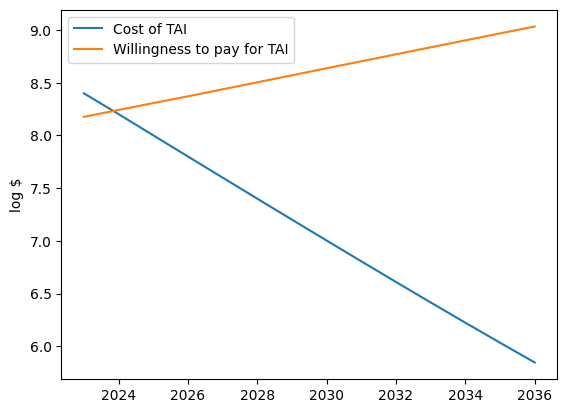

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)